In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

In [14]:
# Set up the generator with a specific seed
g = torch.Generator()
g.manual_seed(4000002)

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(np.int8)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, stratify=y, random_state=42)

# Smaller subset for faster training
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=42)

In [15]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_small.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_small.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

In [17]:
# Define the MLP Model
class MLP(nn.Module):
    def __init__(self, generator):
        super(MLP, self).__init__()
        self.hidden_layer1 = nn.Linear(28*28, 30)
        self.hidden_layer2 = nn.Linear(30, 20)
        self.output_layer = nn.Linear(20, 10)
        self._initialize_weights(generator)

    def _initialize_weights(self, generator):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Using Kaiming He initialization
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the model
model = MLP(generator=g)
untrained_model = MLP(generator=g)


In [18]:
# Step 4: Training the MLP model
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Switch to Adam optimizer
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, epochs=5000):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Train the model
train(model, train_loader, epochs=1000)

model.eval()
with torch.no_grad():
    y_pred_mlp = model(X_test_tensor)
    y_pred_mlp = y_pred_mlp.argmax(dim=1).cpu().numpy()

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_small, y_train_small)
y_pred_rf = rf.predict(X_test)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_small, y_train_small)
y_pred_lr = lr.predict(X_test)

# Step 7: Compute F1-scores
f1_mlp = f1_score(y_test, y_pred_mlp, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
f1_lr = f1_score(y_test, y_pred_lr, average='macro')

print(f"F1-score for MLP: {f1_mlp}")
print(f"F1-score for Random Forest: {f1_rf}")
print(f"F1-score for Logistic Regression: {f1_lr}")

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print(f"confusion matrix for MLP: {cm_mlp}")
print(f"confusion matrix for Random Forest: {cm_rf}")
print(f"confusion matrix for Logistic Regression: {cm_lr}")

F1-score for MLP: 0.9194090569300425
F1-score for Random Forest: 0.9466349727911615
F1-score for Logistic Regression: 0.8676537846222849
confusion matrix for MLP: [[ 944    1    7    0    2   15    9    3    4    1]
 [   0 1095    9    5    1    3    4    4    4    0]
 [   6   13  920   16    6    1   13   12    8    4]
 [   3    2   19  907    1   36    9   12   14   17]
 [   0    2    5    0  874    6    8   17    6   57]
 [   6    1    0   21    5  800   21    6   22   20]
 [  15    1    3    0    5   22  930    0    6    0]
 [   2    5   17    6    4    2    3  957    4   42]
 [   7    6    8   14    3   15   25    0  862   35]
 [   0    9    2    7   11    9    8   27    8  913]]
confusion matrix for Random Forest: [[ 971    1    1    0    1    2    3    1    6    0]
 [   0 1107    2    4    0    4    3    2    1    2]
 [  10    2  941    6   10    1    5   13    8    3]
 [   5    2   23  937    1   17    2   15   15    3]
 [   1    1    1    0  918    0    5    0    3   46]
 [   

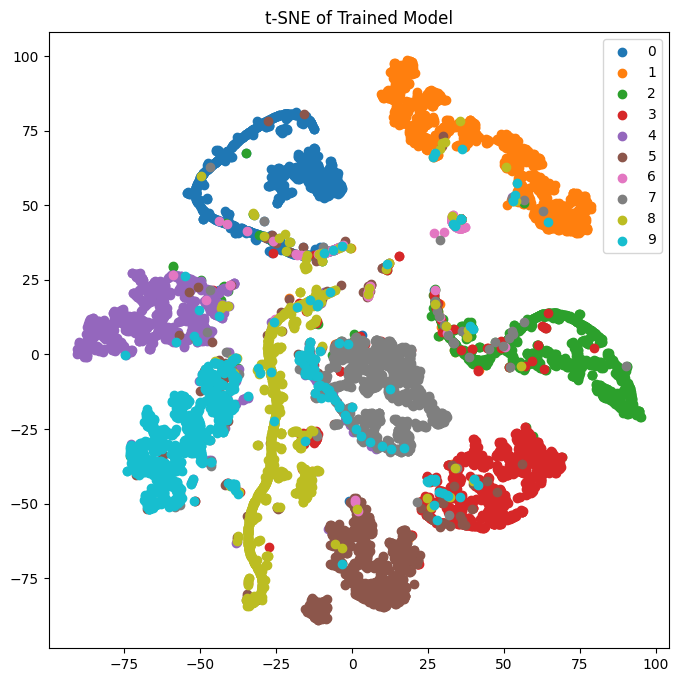

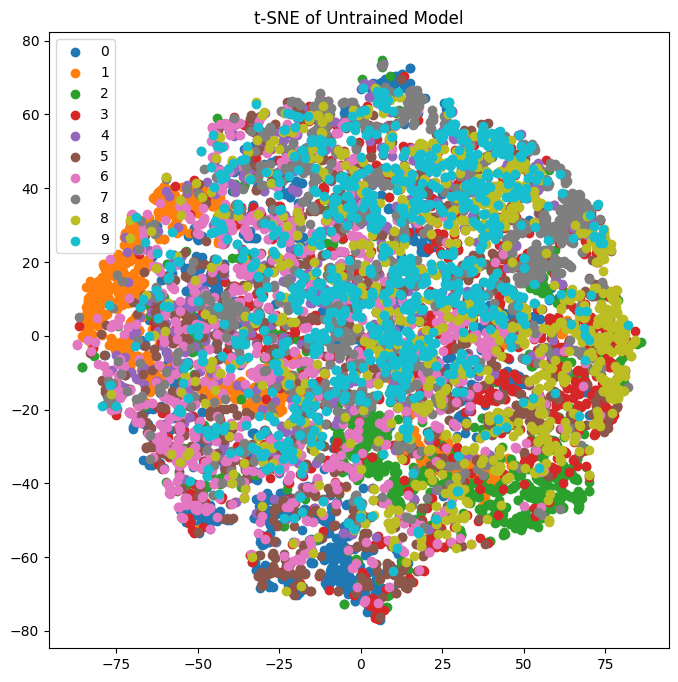

In [20]:
untrained_model = MLP(generator=g)

# Extract features from the second hidden layer
def get_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.view(-1, 28*28)
            hidden_output = torch.relu(model.hidden_layer1(images))
            second_hidden_output = torch.relu(model.hidden_layer2(hidden_output))
            features.append(second_hidden_output)
            labels.append(lbls)
    return torch.cat(features).numpy(), torch.cat(labels).numpy()

# Get features for trained and untrained models
trained_features, trained_labels = get_features(model, test_loader)
untrained_features, untrained_labels = get_features(untrained_model, test_loader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
trained_tsne = tsne.fit_transform(trained_features)
untrained_tsne = tsne.fit_transform(untrained_features)

# Plotting t-SNE
def plot_tsne(tsne_data, labels, title):
    plt.figure(figsize=(8, 8))
    for i in range(10):
        indices = (labels == i)
        plt.scatter(tsne_data[indices, 0], tsne_data[indices, 1], label=str(i))
    plt.legend()
    plt.title(title)
    plt.show()

plot_tsne(trained_tsne, trained_labels, "t-SNE of Trained Model")
plot_tsne(untrained_tsne, untrained_labels, "t-SNE of Untrained Model")

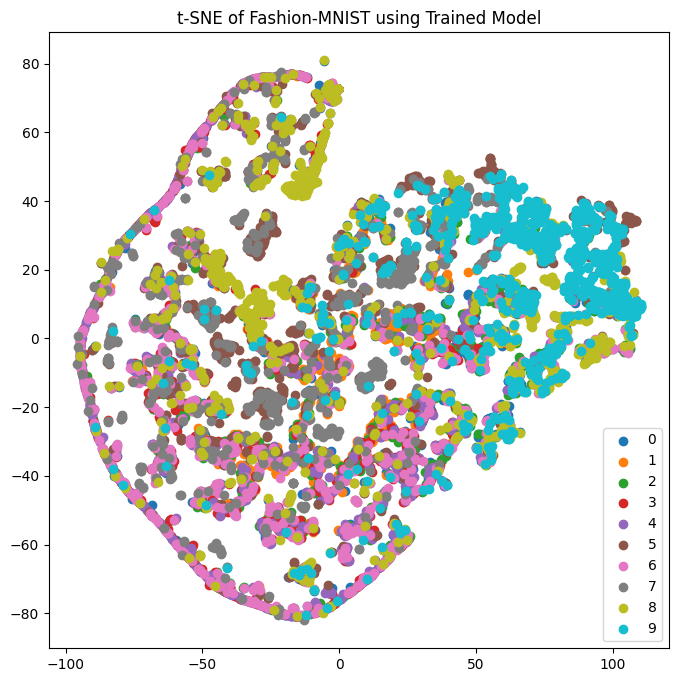

In [21]:
def load_data(name, test_size=10000):
    dataset = fetch_openml(name, version=1)
    X, y = dataset["data"], dataset["target"].astype(np.int8)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test



# Load Fashion-MNIST dataset
X_fashion_train, X_fashion_test, y_fashion_train, y_fashion_test =load_data('Fashion-MNIST')

# Convert Fashion-MNIST data to PyTorch tensors
X_fashion_test_tensor = torch.tensor(X_fashion_test.values, dtype=torch.float32)
y_fashion_test_tensor = torch.tensor(y_fashion_test.values, dtype=torch.long)

# Create Fashion-MNIST test dataset and loader
fashion_test_dataset = TensorDataset(X_fashion_test_tensor, y_fashion_test_tensor)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=10000, shuffle=False)

# Extract features for Fashion-MNIST
fashion_features, fashion_labels = get_features(model, fashion_test_loader)

# Perform t-SNE for Fashion-MNIST
fashion_tsne = tsne.fit_transform(fashion_features)

# Plot t-SNE for Fashion-MNIST
plot_tsne(fashion_tsne, fashion_labels, "t-SNE of Fashion-MNIST using Trained Model")